# Tempo

Tempo should be measured as either the amount of passes and dribbles per time frame, or the speed of those per time frame. It could also include for example goal kicks, free kicks, corner kicks and even shots. Let's start with passes and dribbles.

In [125]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, levene, ks_2samp, ttest_ind
import pingouin as pg

%matplotlib inline

In [126]:
# global variables
timeframe = 1200/4 # 1200 is the duration of one period

In [127]:
# read data
df = pd.read_csv('../data/processed_timelines.csv')

In [128]:
# head
df.head(1)

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,...,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
0,57,1257,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,...,NaN,FC Espoo T2010,EPS T2010,0,0,F12,2022,NaN,NaN,0


In [129]:
df[(df['age'] == 'F14') & (df['year'] == 2024)]

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,...,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
177451,155,3235,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,...,NaN,EPS T2010,Hammarby IF T2010,0,1,F14,2024,NaN,NaN,1
177452,155,3235,Pass,1.0,Successful,Home,3.0,2024-12-13 12:59:57.600000+00:00,2024-12-13 13:00:00.620000+00:00,-21.82,...,12.304505,EPS T2010,Hammarby IF T2010,0,1,F14,2024,37.159604,3.02,1
177453,155,3235,BallContest,1.0,NaN,NaN,6.0,2024-12-13 13:00:00.660000+00:00,2024-12-13 13:00:02.620000+00:00,-3.30,...,NaN,EPS T2010,Hammarby IF T2010,0,1,F14,2024,NaN,1.96,1
177454,155,3235,ThrowIn,1.0,NaN,Home,12.0,NaN,NaN,1.20,...,NaN,EPS T2010,Hammarby IF T2010,0,1,F14,2024,NaN,NaN,1
177455,155,3235,BallContest,1.0,NaN,NaN,13.0,2024-12-13 13:00:07.560000+00:00,2024-12-13 13:00:09.040000+00:00,-4.20,...,NaN,EPS T2010,Hammarby IF T2010,0,1,F14,2024,NaN,1.48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191719,155,3196,BallContest,1.0,NaN,NaN,1763.0,2024-12-11 11:31:10.820000+00:00,2024-12-11 11:31:11.520000+00:00,-41.87,...,NaN,EPS T2010,FC Nordsjaelland T2010,0,1,F14,2024,NaN,0.70,1
191720,155,3196,Pass,1.0,Successful,Away,1763.0,2024-12-11 11:31:11.460000+00:00,2024-12-11 11:31:14.840000+00:00,-41.01,...,7.628897,EPS T2010,FC Nordsjaelland T2010,0,1,F14,2024,25.785672,3.38,1
191721,155,3196,Pass,1.0,Successful,Away,1770.0,2024-12-11 11:31:17.820000+00:00,2024-12-11 11:31:21.640000+00:00,-34.14,...,9.278415,EPS T2010,FC Nordsjaelland T2010,0,1,F14,2024,35.443544,3.82,1
191722,155,3196,Pass,1.0,Successful,Home,1785.0,2024-12-11 11:31:32.620000+00:00,2024-12-11 11:31:34.540000+00:00,-43.23,...,8.166673,EPS T2010,FC Nordsjaelland T2010,0,1,F14,2024,15.680013,1.92,1


In [130]:
# group by matches
df_matches = df.groupby('match_id')

In [131]:
# get matches with time gaps between events of over 50 seconds
threshold = 50

# Compute time gaps
df['time_gap'] = df_matches['seconds_from_period_start'].diff()

# Identify matches with gaps above threshold
df['gap_exceeds_threshold'] = df['time_gap'] > threshold
df['gap_exceeds_threshold_300'] = df['time_gap'] > 300

In [132]:
# get matches where two consecutive events are kick-offs
df['consecutive_kickoffs'] = (df['event_type'] == 'KickOff') & (df['event_type'].shift(1) == 'KickOff')

In [133]:
# get matches with under 300 events
event_counts = df.groupby('match_id').size().reset_index(name='event_count')
too_few_events_ids = event_counts['match_id'][event_counts['event_count'] < 300]

We should decide which matches we want to keep. Some matches have large gaps between events, which could be pauses in the match or an error of the data gathering system. Below are a few options.

In [134]:
# remove matches where two consecutive events are kickoffs and have at least a 50 second gap
# remove_match_indices = df[(df['gap_exceeds_threshold'] == True) & (df['consecutive_kickoffs'] == True)]['match_id'].unique()
# df = df[~df['match_id'].isin(remove_match_indices)]

In [135]:
# remove matches with time gaps of over five minutes and matches with less than 300 events
remove_match_indices = df[(df['gap_exceeds_threshold_300'] == True)]['match_id'].unique()
remove_match_indices = list(set(remove_match_indices) | set(too_few_events_ids))
df = df[~df['match_id'].isin(remove_match_indices)].copy()

In [136]:
# finally, create a match info df with match ids, teams, internationality, age and year
match_info_df = df.loc[:, ['match_id', 'home_team', 'away_team',
                           'home_team_int', 'away_team_int', 'int_level',
                           'age', 'year']].drop_duplicates(subset=['match_id'])

In [137]:
# save as csv
match_info_df.to_csv('../data/match_info.csv', index=False)

### Plotting

In [138]:
# Function to calculate passes, dribbles & shots per timeframe
def calculate_tempo(df, timeframe):
    
    # Create time bins
    df.loc[:,'time_bin'] = (df['seconds_from_period_start'] // timeframe) * timeframe
    
    # Count passes, dribbles & shots per time bin
    df = df[df['event_type'].isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick'])] \
        .groupby(['match_id', 'time_bin', 'age', 'year', 'int_level']).size().reset_index(name='tempo')
    
    return df

In [139]:
# get the tempo dataframe
tempo_df = calculate_tempo(df, timeframe)

In [140]:
# print distribution of match durations to drop time bins with only a few instances
tempo_df['time_bin'].value_counts()

time_bin
600.0     430
900.0     430
1200.0    430
300.0     429
1500.0    429
0.0       428
1800.0    408
2100.0    299
2400.0    268
2700.0     19
3000.0     13
3300.0      1
Name: count, dtype: int64

We can see that only a few matches have played over the 2400 second mark. We should ignore these time bins as they are not representative of the population.

In [141]:
# exclude the last incomplete time frames

# Find the max time_bin for each match_id
max_time_bins = tempo_df.groupby('match_id')['time_bin'].transform('max')

# Keep only rows where time_bin is NOT the max for that match
# For age groups M12, M14 and F14 some years tournaments only have match lengts of 30 minutes, this creates a lot of missing
tempo_df = tempo_df[tempo_df['time_bin'] != max_time_bins]
tempo_df = tempo_df[tempo_df['time_bin'] <= 2100]

In [142]:
# # missing values
# age_timebin_means = tempo_df.groupby(["age", "time_bin"])["tempo"].transform(lambda x: x.median())

# # Fill missing values in 'tempo' with the computed mean
# tempo_df["tempo"] = tempo_df["tempo"].fillna(age_timebin_means)

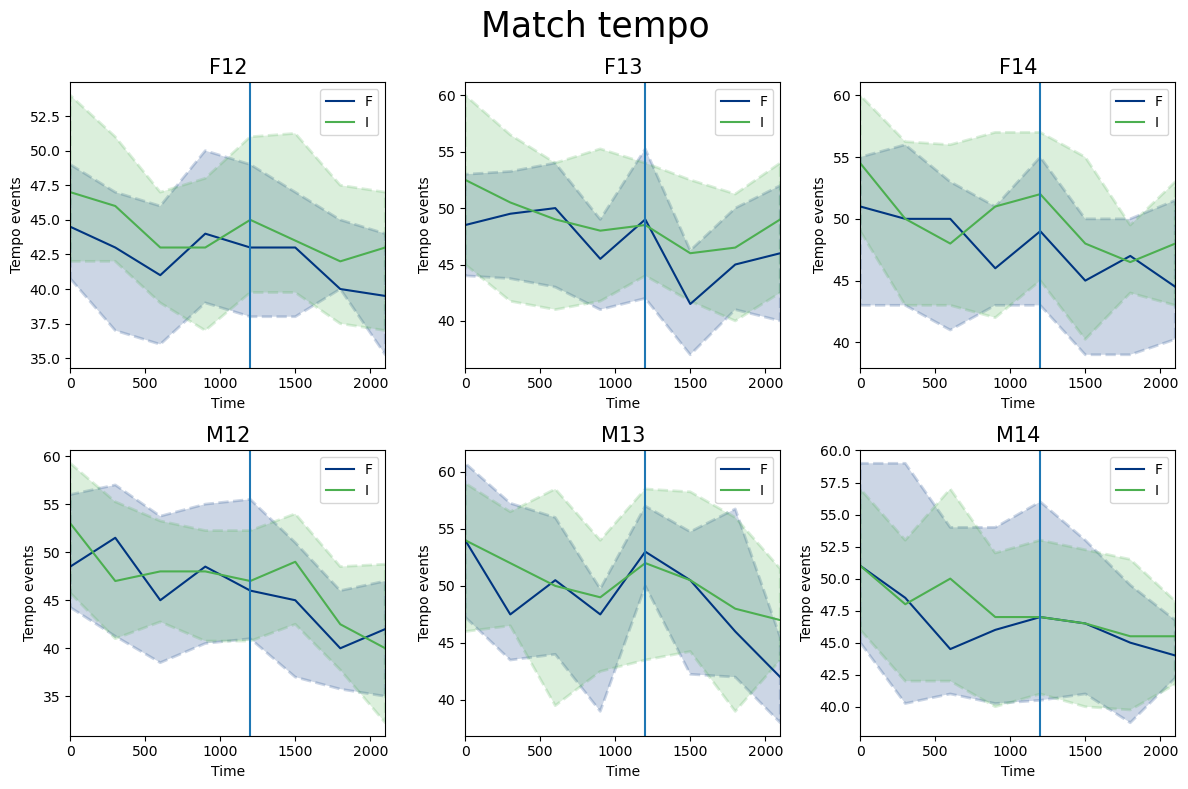

In [143]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2,3, figsize=(12,8))

colors = ['#003580', '#4caf50', '#d50000'] # blue, green, red

axes = axes.flatten()

df_grouped = tempo_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):

    for level in [0, 1]:
        subset = df_group[df_group['int_level'] == level]
        avg = subset.groupby('time_bin')['tempo'].median()
        l_q = subset.groupby('time_bin')['tempo'].quantile(q=0.25)
        h_q = subset.groupby('time_bin')['tempo'].quantile(q=0.75)
        axes[i].plot(avg, color=colors[level], label=f'{['F', 'I'][level]}')
        axes[i].fill_between(avg.index, l_q, h_q, color=colors[level], alpha=.2, linestyle='--', linewidth=2, interpolate=True)
        
    axes[i].set_xlim([avg.index[0], avg.index[-1]])
    axes[i].set_title(group_name, fontsize=15)
    axes[i].axvline(1200)
    axes[i].legend()  # Add legend to differentiate int_level categories
    axes[i].set_xlabel('Time', fontsize=10)
    axes[i].set_ylabel('Tempo events', fontsize=10)

fig.suptitle('Match tempo', fontsize=25)
plt.tight_layout()

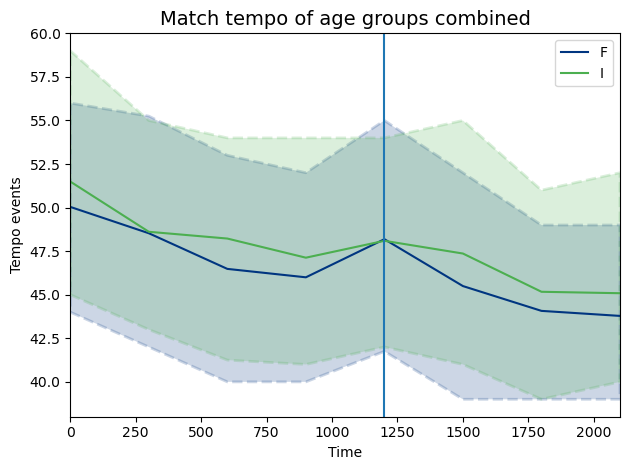

In [144]:
# plot tempo

colors = ['#003580', '#4caf50', '#d50000']

for level in [0, 1]:
    subset = tempo_df[tempo_df['int_level'] == level]
    l_q = subset.groupby('time_bin')['tempo'].quantile(q=0.25)
    h_q = subset.groupby('time_bin')['tempo'].quantile(q=0.75)
    avg = subset.groupby('time_bin')['tempo'].mean()
    plt.plot(avg, color=colors[level], label=f'{['F', 'I'][level]}')
    plt.fill_between(avg.index, l_q, h_q, color=colors[level], alpha=.2, linestyle='--', linewidth=2, interpolate=True)

plt.xlim([avg.index[0], avg.index[-1]])
plt.title('Match tempo of age groups combined', fontsize=14)
plt.axvline(1200)
plt.legend()  # Add legend to differentiate int_level categories
plt.xlabel('Time')
plt.ylabel('Tempo events')

plt.tight_layout()

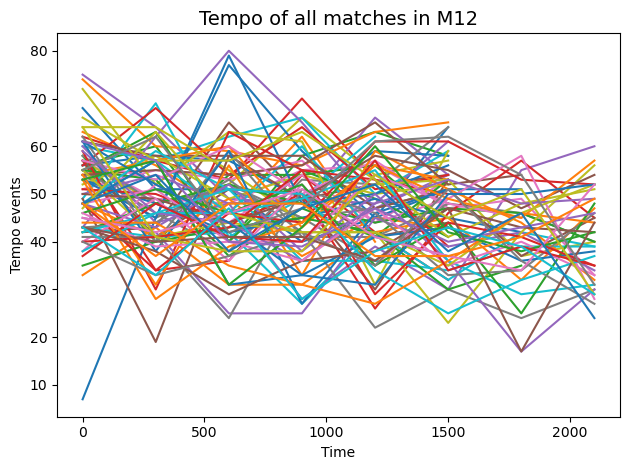

In [145]:
subset = tempo_df[tempo_df['age'] == 'M12']
match_grouped = subset.groupby('match_id')

for m_name, m in match_grouped:
    plt.plot(m['time_bin'], m['tempo'])

plt.title('Tempo of all matches in M12', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Tempo events')

plt.tight_layout()

In [146]:
# statistical tests

age_groups = tempo_df['age'].unique()

for age in age_groups:
    subset = tempo_df[tempo_df['age'] == age]
    print(f'Age group {age}')
    time_bins = subset['time_bin'].unique()
    for bin in time_bins:
        subset_tempo = subset.loc[subset['time_bin'] == bin, 'tempo']
        stat, p = shapiro(subset_tempo)
        print(f"Time Bin {bin}: Shapiro-Wilk Test p-value = {p}")

Age group F12
Time Bin 0.0: Shapiro-Wilk Test p-value = 0.37699969100647446
Time Bin 300.0: Shapiro-Wilk Test p-value = 0.021956319578157614
Time Bin 600.0: Shapiro-Wilk Test p-value = 0.9154778961044203
Time Bin 900.0: Shapiro-Wilk Test p-value = 0.6626873643400722
Time Bin 1200.0: Shapiro-Wilk Test p-value = 0.961435761609611
Time Bin 1500.0: Shapiro-Wilk Test p-value = 0.8306074579434068
Time Bin 1800.0: Shapiro-Wilk Test p-value = 0.11642655526398349
Time Bin 2100.0: Shapiro-Wilk Test p-value = 0.2130734070204261
Age group M12
Time Bin 0.0: Shapiro-Wilk Test p-value = 0.0025244476353556344
Time Bin 300.0: Shapiro-Wilk Test p-value = 0.531714972901352
Time Bin 600.0: Shapiro-Wilk Test p-value = 0.04943854772993891
Time Bin 900.0: Shapiro-Wilk Test p-value = 0.7085804250692425
Time Bin 1200.0: Shapiro-Wilk Test p-value = 0.7347149599183531
Time Bin 1500.0: Shapiro-Wilk Test p-value = 0.3915983623535701
Time Bin 1800.0: Shapiro-Wilk Test p-value = 0.11755334447164179
Time Bin 2100.0: 

Shapiro-Wilk normality test shows that the null hypothesis of normal distribution can not be rejected. Most of the time bins are clearly normally distributed. We can test statistical significance time bin -wise and as a whole. The mixed model ANOVA test can be used to test hypothesis of repeated measures. In this case the between subject are the time bins within a match. In addition to normality, for the mixed model ANOVA, we also need to test the homogenity of variances (Levene's test) and homogenity of covariances (Mauchly's test of sphericity). We split the matches by age groups, which creates six different tests with independent subjects. We also need to address outliers.

In [147]:
# homogenity of variances between int levels per time bin
age_groups = tempo_df['age'].unique()

for age in age_groups:
    subset = tempo_df[tempo_df['age'] == age]
    print(f'Age group {age}')
    time_bins = subset['time_bin'].unique()
    for bin in time_bins:
        subset_tempo = subset.loc[subset['time_bin'] == bin, ['tempo', 'int_level']]
        int_levels = []
        for i in range(2):
            int_level = subset_tempo.loc[subset_tempo['int_level'] == i, 'tempo']
            int_levels.append(int_level)
        stat, p = levene(int_levels[0], int_levels[1])
        print(f"Time Bin {bin}: Levene's Test p-value = {p}")

Age group F12
Time Bin 0.0: Levene's Test p-value = 0.5834538065938972
Time Bin 300.0: Levene's Test p-value = 0.37431778974519525
Time Bin 600.0: Levene's Test p-value = 0.4907352101431164
Time Bin 900.0: Levene's Test p-value = 0.8496864001208042
Time Bin 1200.0: Levene's Test p-value = 0.38916735174161143
Time Bin 1500.0: Levene's Test p-value = 0.5258938844405048
Time Bin 1800.0: Levene's Test p-value = 0.14809623791895063
Time Bin 2100.0: Levene's Test p-value = 0.7985791226833405
Age group M12
Time Bin 0.0: Levene's Test p-value = 0.748265597865226
Time Bin 300.0: Levene's Test p-value = 0.4887398423133579
Time Bin 600.0: Levene's Test p-value = 0.5996241053479128
Time Bin 900.0: Levene's Test p-value = 0.9921863258506944
Time Bin 1200.0: Levene's Test p-value = 0.9793185047541445
Time Bin 1500.0: Levene's Test p-value = 0.46583949840725825
Time Bin 1800.0: Levene's Test p-value = 0.1575084767183579
Time Bin 2100.0: Levene's Test p-value = 0.5695197140779047
Age group F13
Time Bi

In [148]:
# homogenity of variances between time bins per int level
age_groups = tempo_df['age'].unique()

for age in age_groups:
    subset = tempo_df[tempo_df['age'] == age]
    print(f'Age group {age}')
    for i in range(2):
        int_level = subset.loc[subset['int_level'] == i, ['tempo', 'time_bin']]
        time_bin_groups = []
        time_bins = tempo_df['time_bin'].unique()
        for bin in time_bins:
            subset_tempo = int_level.loc[int_level['time_bin'] == bin, 'tempo']
            time_bin_groups.append(subset_tempo)
        stat, p = levene(*time_bin_groups)
        print(f"Int level {i}: Levene's Test p-value = {p}")

Age group F12
Int level 0: Levene's Test p-value = 0.6939980364215421
Int level 1: Levene's Test p-value = 0.9953474938070048
Age group M12
Int level 0: Levene's Test p-value = 0.51340961557106
Int level 1: Levene's Test p-value = 0.9999739257468049
Age group F13
Int level 0: Levene's Test p-value = 0.9867914379555156
Int level 1: Levene's Test p-value = 0.8603159401998518
Age group F14
Int level 0: Levene's Test p-value = 0.7055643171336059
Int level 1: Levene's Test p-value = 0.29965944071905987
Age group M13
Int level 0: Levene's Test p-value = 0.9411213800455059
Int level 1: Levene's Test p-value = 0.044832683500423236
Age group M14
Int level 0: Levene's Test p-value = 0.24192735489925224
Int level 1: Levene's Test p-value = 0.11707832946958922


The Levene test tests the null hypothesis that all input samples are from populations with equal variances. We cannot reject this null hypothesis, so we can assume that they are for both dimensions.

In [149]:
# pivot the table to hold each match as a single row, with the timebins included as variables
df_pivot = tempo_df.pivot(index=['match_id', 'age', 'year', 'int_level'], columns='time_bin', values='tempo')

# reset index to make it a normal DataFrame
df_pivot.reset_index(inplace=True)

# rename the columns for clarity
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns=lambda x: f"time_bin_{int(x)}" if isinstance(x, float) else x)

In [150]:
# # Assuming df is your dataframe
# time_bin_cols = [col for col in df_pivot.columns if col.startswith("time_bin")]

# # Compute mean per age group for each time bin
# age_group_means = df_pivot.groupby("age")[time_bin_cols].transform(lambda x: x.mean())

# # Fill NaNs with the corresponding mean
# df_pivot[time_bin_cols] = df_pivot[time_bin_cols].fillna(age_group_means)

Tournaments M12 and M14 in 2022 as well as F14 and M14 in 2024 have durations of 2x15min which means only six time bins.

In [151]:
# homogenity of covariances, mauchly's test for the within subject factors (time bins)
age_groups = tempo_df['age'].unique()

for age in age_groups:
    subset = tempo_df[tempo_df['age'] == age]
    print(f'Age group {age}')
    spher, _, chisq, dof, p = pg.sphericity(subset, dv='tempo',
                                           subject='match_id',
                                           within='time_bin')
    print(f"Mauchly's Test p-value = {p}")

Age group F12
Mauchly's Test p-value = 0.2844309786984758
Age group M12
Mauchly's Test p-value = 0.3243555949717843
Age group F13
Mauchly's Test p-value = 0.4674586835174636
Age group F14
Mauchly's Test p-value = 0.31550383793990616
Age group M13
Mauchly's Test p-value = 0.02342363516294242
Age group M14
Mauchly's Test p-value = 0.13664715157970478


Mauchly's test shows that the sphericity in M13 needs to be corrected.

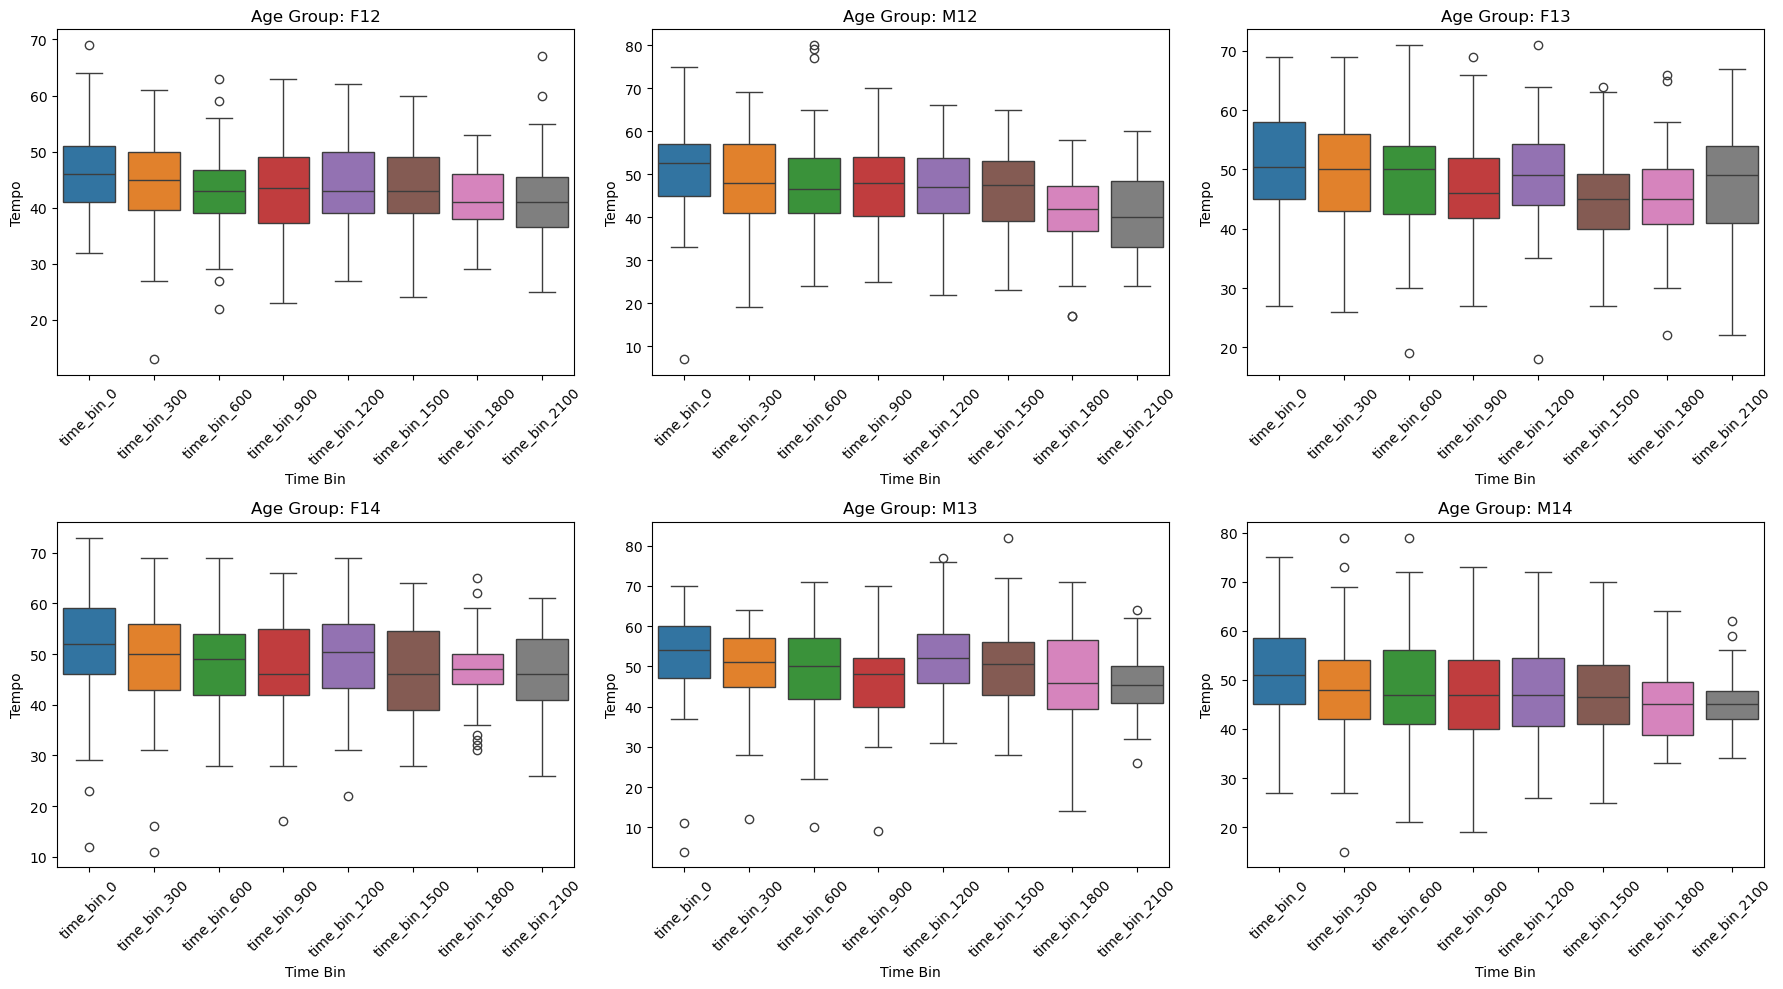

In [152]:
# Get unique age groups
age_groups = df_pivot['age'].unique()

# Set up the figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each age group and create a box plot
for i, age in enumerate(age_groups):
    subset = df_pivot[df_pivot['age'] == age]
    sns.boxplot(data=subset.iloc[:, 4:12], ax=axes[i])  # Select only time bin columns
    axes[i].set_title(f"Age Group: {age}")
    axes[i].set_xlabel("Time Bin")
    axes[i].set_ylabel("Tempo")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Adjust layout for clarity
plt.tight_layout()
plt.show()


In [153]:
# two-way repeated measures ANOVA, automatically corrects the M13 sphericity

age_groups = tempo_df['age'].unique()

for age in age_groups:
    subset = tempo_df[tempo_df['age'] == age]
    print(f'Age group {age}')
    aov = pg.mixed_anova(dv='tempo', within='time_bin', between='int_level',
                    subject='match_id', data=subset)
    pg.print_table(aov)

Age group F12

ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  -------  -----  -----  -------  -----  -------  -----  -------
int_level    506.712      1     44  506.712  3.180    0.081  0.067  nan
time_bin     744.424      7    308  106.346  2.489    0.017  0.054    0.845
Interaction   89.848      7    308   12.835  0.300    0.953  0.007  nan

Age group M12

ANOVA SUMMARY

Source             SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  --------  -----  -----  -------  -----  -------  -----  -------
int_level     163.395      1     41  163.395  0.983    0.327  0.023  nan
time_bin     1961.860      7    287  280.266  3.814    0.001  0.085    0.855
Interaction   310.269      7    287   44.324  0.603    0.753  0.014  nan

Age group F13

ANOVA SUMMARY

Source             SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  --------  -----  -----  -------  -----  -------  -----  -------
int_l

From the two-way repeated measures ANOVA model, we can observe that for many age groups the difference in the time bins is statistically significant. We can say that the tempo decreases during the match statistically significantly. The internationality level is not a significant factor in measuring the tempo, although close in a few age groups. We should run the Kolmogorov-Smirnov test with single tempo values per match. First, we need to determine the overall tempo of the match, then these values form a distribution for each group. The differences in these distributions can be tested with the KS-test.

In [154]:
# create a dataframe with a single tempo value for each match, easily derived from tempo_df
overall_tempo_df = tempo_df.groupby("match_id").agg(
    event_count=("tempo", "sum"),
    duration=("time_bin", "max")
).reset_index()

# duration is the last time bin + 300
overall_tempo_df["duration"] += 300

# create tempo column
overall_tempo_df['tempo'] = overall_tempo_df['event_count'] / (overall_tempo_df['duration'] / 60)

# add a few info columns from match_info_df
overall_tempo_df = overall_tempo_df.merge(match_info_df.loc[:, ['match_id', 'int_level', 'age','year']], on='match_id', how='inner')


Age group F12
Kolmogorov-Smirnov Test p-value = 0.37194929827678713
Age group M12
Kolmogorov-Smirnov Test p-value = 0.8507500249360188
Age group F13
Kolmogorov-Smirnov Test p-value = 0.04393596798764922
Age group F14
Kolmogorov-Smirnov Test p-value = 0.07342661523107603
Age group M13
Kolmogorov-Smirnov Test p-value = 0.5779263389772872
Age group M14
Kolmogorov-Smirnov Test p-value = 0.9273480443075207


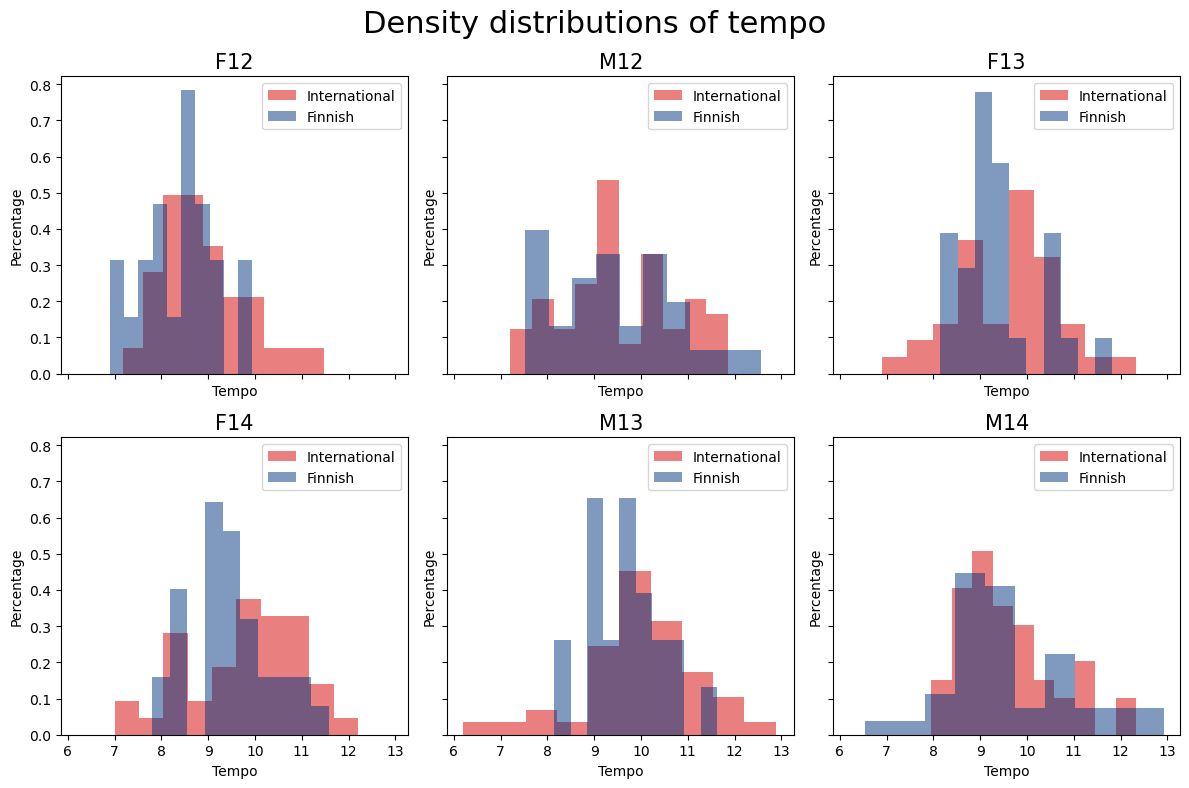

In [155]:
# kolmogorov-smirnov test for each age group
age_groups = overall_tempo_df['age'].unique()

# Define plot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

for i, age in enumerate(age_groups):
    subset = overall_tempo_df[overall_tempo_df['age'] == age]
    print(f'Age group {age}')
    tempo_dom = subset.loc[subset['int_level'] == 0, 'tempo']
    tempo_int = subset.loc[subset['int_level'] == 1, 'tempo']
    ks_stat, p = ks_2samp(tempo_int, tempo_dom)
    print(f"Kolmogorov-Smirnov Test p-value = {p}")

    ax = axes[i]

    # Plot first histogram (overlap=True)

    ax.hist(tempo_int,  
        alpha=0.5, 
        label='International',
        color=colors[1],
        density=True) 

    ax.hist(tempo_dom, 
        alpha=0.5, 
        label='Finnish',
        color=colors[0],
        density=True) 

    ax.set_xlabel('Tempo', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{age}', fontsize=15)
    ax.legend()

plt.suptitle("Density distributions of tempo", fontsize=22)
plt.tight_layout()
plt.show()

In [166]:
# t-test
age_groups = overall_tempo_df['age'].unique()

for age in age_groups:
    subset = overall_tempo_df[overall_tempo_df['age'] == age]
    print(f'Age group {age}')
    tempo_dom = subset.loc[subset['int_level'] == 0, 'tempo']
    tempo_int = subset.loc[subset['int_level'] == 1, 'tempo']
    t_stat, p_value = ttest_ind(tempo_int, tempo_dom, equal_var=True)  # Assuming equal variance
    print(f"T-test p-value: {p_value:.4f}")

Age group F12
T-test p-value: 0.0370
Age group M12
T-test p-value: 0.7519
Age group F13
T-test p-value: 0.3117
Age group F14
T-test p-value: 0.2378
Age group M13
T-test p-value: 0.4301
Age group M14
T-test p-value: 0.8346


Neither of the KS-test and the t-test show statistical significant difference in the tempo distributions. With the t-test we get a significant p-value for the age group F12, and with the KS-test one for F13. One for each is not a strong indication that there would be a statistically significant difference between the tempos in domestic and international matches.

We will focus next on the team-wise tempo per possession. For this we need to first derive the team in position in each moment. Then we can derive the duration of said possession, and calculate the amount of passes and dribbles per possession.

In [157]:
# simplify data frame
simple_df = df[['match_id', 'event_type', 'team', 'result', 'seconds_from_period_start', 'home_team_int', 'away_team_int', 'age', 'time_gap', ]]

We will next calculate possessions. Possession is classified as at least five consecutive events of the same team. The duration of the possession is calculated. Large gaps within possessions are ignored, and replaced with the average gap between two passes of the team in the match. The events in a possession are counted, and then the tempo of the possession is calculated as events/minute.

In [158]:
# group by matches
grouped_matches = simple_df.groupby('match_id')

# initialize list to store possession dfs of individual matches
df_list = []


for group_name, df_group in grouped_matches:

    # create a possession identifier by checking when the value changes
    df_group.loc[:, 'possession_id'] = (df_group['team'] != df_group['team'].shift()).cumsum()

    # calculate possession duration
    df_group.loc[:, 'possession_duration'] = df_group.groupby('possession_id')['seconds_from_period_start'].transform('max') - \
                                df_group.groupby('possession_id')['seconds_from_period_start'].transform('min')

    # compute average pass gap in possession to help reduce gaps
    df_group.loc[:, 'prev_event_type'] = df_group.groupby('possession_id')['event_type'].shift(1)
    home_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Home'), 'time_gap'].mean()
    away_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Away'), 'time_gap'].mean()

    # Filter possessions that have at least 3 events
    valid_possessions = df_group.groupby(['match_id', 'team', 'possession_id']).filter(lambda x: len(x) >= 5)

    # Detect if any possession has a gap ≥ 10 seconds
    possessions_with_gaps = (
        valid_possessions.groupby(['match_id', 'team', 'possession_id'])['time_gap']
        .apply(lambda x: x.iloc[1:].max())  # Skip first row and take max
        .reset_index(name='max_time_gap')
    )
    possessions_with_gaps['has_large_gap'] = possessions_with_gaps['max_time_gap'] >= 10

    # Group by possession and calculate tempo event counts
    df_possessions = valid_possessions.groupby(['match_id', 'possession_id']).agg(
        pos_duration=('possession_duration', 'first'),
        pos_start_time=('seconds_from_period_start', 'first'),
        tempo_event_count=('event_type', lambda x: x.isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick']).sum()),  # Count passes
    ).reset_index()

    df_possessions = df_possessions.merge(possessions_with_gaps, on=['match_id', 'possession_id'], how='left')

    # remove large gaps from possessions to limit pauses in possessions
    df_possessions['new_possession_duration'] = df_possessions.apply(
        lambda row: row['pos_duration'] - (row['max_time_gap'] - home_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Home')) 
                        else (row['pos_duration'] - (row['max_time_gap'] - away_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Away'))
                        else row['pos_duration']),
        axis=1)
    
    # remove possessions with duration 0
    df_possessions = df_possessions[df_possessions['pos_duration'] != 0]

    # Calculate tempo as events per minute
    df_possessions['pos_tempo'] = (df_possessions['tempo_event_count']) / (df_possessions['pos_duration']/60)

    # add df to list
    df_list.append(df_possessions)

# combine match dfs
pos_tempo_df = pd.concat(df_list, ignore_index=True)

In [159]:
# combine team internationality, age and year to the dataframe
pos_tempo_df = pos_tempo_df.merge(match_info_df.loc[:, ['match_id', 'home_team_int', 'away_team_int', 'age', 'year']],
                    how='left', on='match_id')

In [160]:
pos_tempo_df

,match_id,possession_id,pos_duration,pos_start_time,tempo_event_count,team,max_time_gap,has_large_gap,new_possession_duration,pos_tempo,home_team_int,away_team_int,age,year
0,1237,51,10.0,290.0,5,Away,4.0,False,10.000000,30.000000,0,1,F12,2022
1,1237,82,10.0,523.0,5,Away,4.0,False,10.000000,30.000000,0,1,F12,2022
2,1237,87,14.0,579.0,5,Home,5.0,False,14.000000,21.428571,0,1,F12,2022
3,1237,112,17.0,746.0,6,Away,6.0,False,17.000000,21.176471,0,1,F12,2022
4,1237,140,22.0,959.0,6,Away,8.0,False,22.000000,16.363636,0,1,F12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,3301,168,19.0,1386.0,5,Home,8.0,False,19.000000,15.789474,0,0,M12,2024
5790,3301,210,63.0,1754.0,7,Home,33.0,True,34.579365,6.666667,0,0,M12,2024
5791,3301,267,12.0,2242.0,5,Home,6.0,False,12.000000,25.000000,0,0,M12,2024
5792,3301,274,29.0,2332.0,8,Home,7.0,False,29.000000,16.551724,0,0,M12,2024


Now we have a dataframe of all matches with possessions as instances. Each possession has a duration and event count from which the tempo is calculated. Now we can analyse the differences of possessional tempo of international vs. Finnish teams.

In [161]:
# calculate new dataframe of average values of international and finnish teams by age groups for plotting

# possessions teams internationality
def possession_internationality(row):
    if row['team'] == 'Home':
        return row['home_team_int']
    elif row['team'] == 'Away':
        return row['away_team_int']
    else:
        return np.nan

pos_tempo_df.loc[:, 'pos_int'] = pos_tempo_df.apply(possession_internationality, axis=1)

# Create time bins of 5 minutes
pos_tempo_df.loc[:, 'time_bin'] = (pos_tempo_df['pos_start_time'] // timeframe) * timeframe

# compute medians and quantiles
df_grouped = pos_tempo_df.groupby(['age', 'pos_int', 'time_bin'])['pos_tempo'].agg(
    median=lambda x: x.median(),
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

In [163]:
# check frequence of time bins
pos_tempo_df['time_bin'].value_counts()

time_bin
0.0       963
300.0     844
600.0     797
1200.0    790
900.0     768
1500.0    685
1800.0    444
2100.0    406
2400.0     71
2700.0     24
3000.0      2
Name: count, dtype: int64

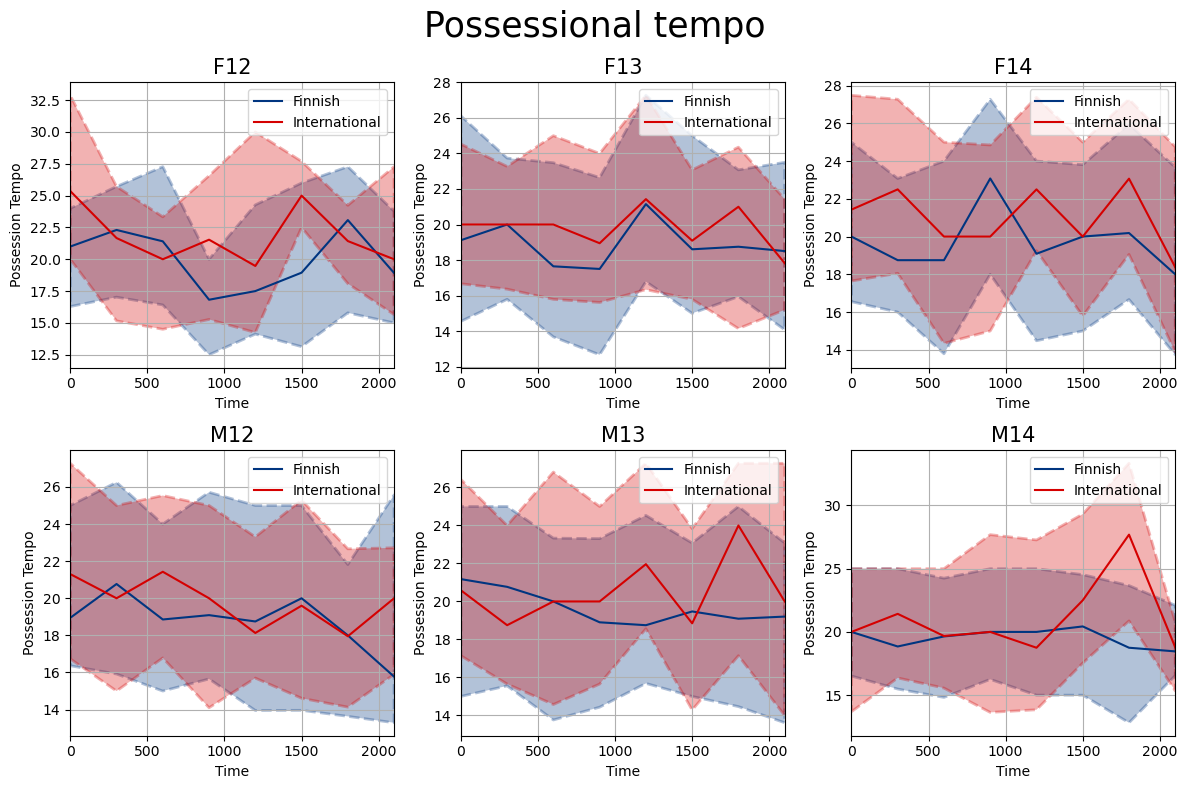

In [164]:
# plot possessional average tempos by age group and team internationality

# age groups
ages = df_grouped.groupby('age')

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

colors = ['#003580', '#d50000']

for i, (age, age_df) in enumerate(ages):
    ax = axes[i]

    pos_ints = age_df.groupby('pos_int')

    for pos_int_val, pos_int in pos_ints:
        df_filtered = pos_int[pos_int['time_bin'] <= 2100] # drop time bins after the full time
        ax.plot(df_filtered['time_bin'], df_filtered['median'], color=colors[pos_int_val], label=f'{['Finnish', 'International'][pos_int_val]}')
        ax.fill_between(df_filtered['time_bin'], df_filtered['q25'], df_filtered['q75'], color=colors[pos_int_val], alpha=.3, linestyle='--', linewidth=2, interpolate=True)

    ax.set_xlim([df_filtered.iloc[0, 2], df_filtered.iloc[-1, 2]])
    ax.set_title(f'{age}', fontsize=15)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Possession Tempo', fontsize=10)
    ax.legend()
    ax.grid(True)

fig.suptitle('Possessional tempo', fontsize=25)
plt.tight_layout()  # Adjust layout for readability
plt.show()


Next, we will plot distributions of possessional tempo as histograms.

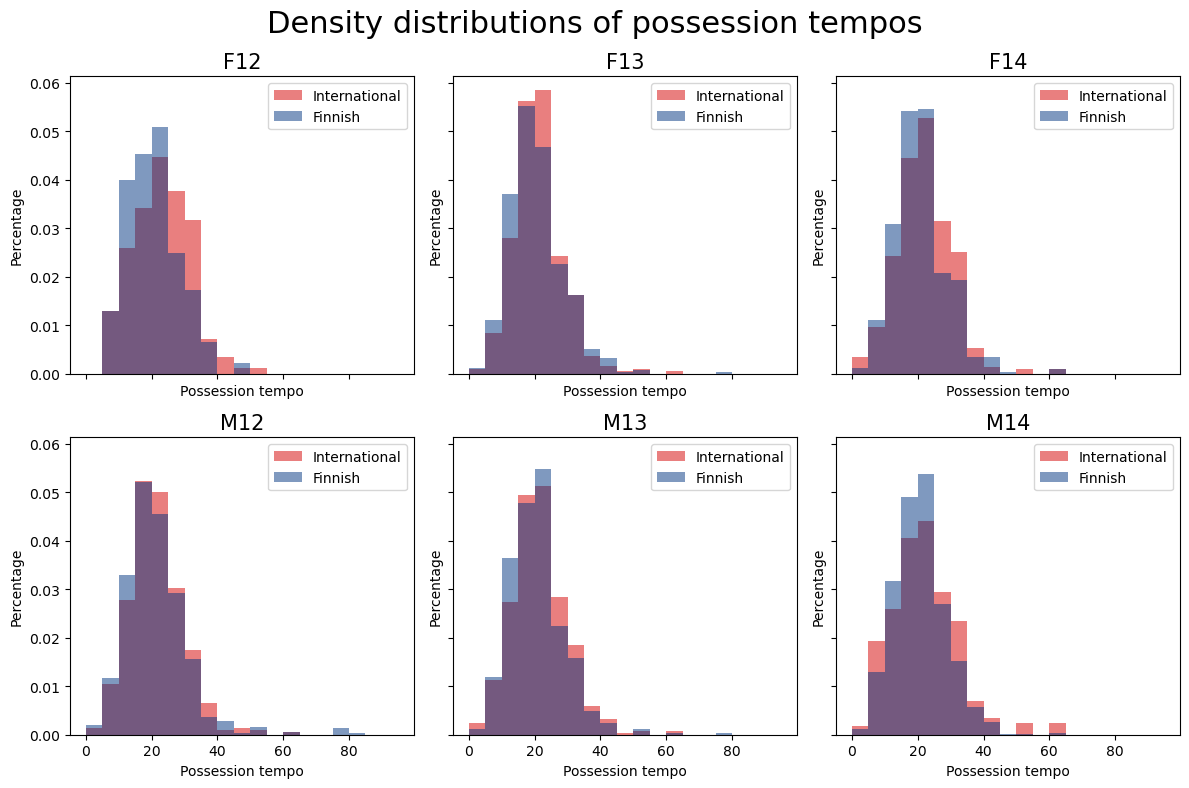

In [165]:
# Define plot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

# Iterate over groups and plot
for i, (group, group_df) in enumerate(pos_tempo_df.groupby('age')):
     ax = axes[i]

     # Plot first histogram (overlap=True)

     ax.hist(group_df[group_df['pos_int'] == 1]['pos_tempo'],  
          alpha=0.5, 
          label='International',
          bins=range(0,100,5),
          color=colors[1],
          density=True) 

     ax.hist(group_df[group_df['pos_int'] == 0]['pos_tempo'], 
          alpha=0.5, 
          label='Finnish',
          bins=range(0,100,5),
          color=colors[0],
          density=True) 
    
     ax.set_xlabel('Possession tempo', fontsize=10)
     ax.set_ylabel('Percentage', fontsize=10)
     ax.set_title(f'{group}', fontsize=15)
     ax.legend()

plt.suptitle("Density distributions of possession tempos", fontsize=22)
plt.tight_layout()
plt.show()

The distribution of match tempos are clearly higher with international teams. From the timeline plots, the difference is not as clear, but from the distribution histograms, the international distribution stands to the right of the distribution of the Finnish teams. We can check the statistical significance with the KS-test.

In [174]:
# kolmogorov-smirnov test for each age group
age_groups = pos_tempo_df['age'].unique()

for i, age in enumerate(age_groups):
    subset = pos_tempo_df[pos_tempo_df['age'] == age]
    print(f'Age group {age}\n')
    tempo_dom = subset.loc[subset['pos_int'] == 0, 'pos_tempo']
    tempo_int = subset.loc[subset['pos_int'] == 1, 'pos_tempo']
    ks_stat, p = ks_2samp(tempo_int, tempo_dom)
    print(f"The means of the possession tempos of domestic and international teams\n\
          Dom: {tempo_dom.mean()}, Int: {tempo_int.mean()}\n")
    print(f"Kolmogorov-Smirnov Test p-value = {p}\n")

Age group F12

The means of the possession tempos of domestic and international teams
          Dom: 20.258997613410738, Int: 22.62435992849196

Kolmogorov-Smirnov Test p-value = 0.008045664198224655

Age group M12

The means of the possession tempos of domestic and international teams
          Dom: 20.937195117466505, Int: 20.954111213163785

Kolmogorov-Smirnov Test p-value = 0.476604180421822

Age group F13

The means of the possession tempos of domestic and international teams
          Dom: 20.144465078627302, Int: 20.7120959800569

Kolmogorov-Smirnov Test p-value = 0.09547533717137258

Age group F14

The means of the possession tempos of domestic and international teams
          Dom: 20.612929373064777, Int: 21.53337886044559

Kolmogorov-Smirnov Test p-value = 0.025999553396135876

Age group M13

The means of the possession tempos of domestic and international teams
          Dom: 20.292627351625132, Int: 21.140756744651586

Kolmogorov-Smirnov Test p-value = 0.12980676814664147


When comparing possessional tempo, we can get a more precise look into the difference between domestic and international teams. For age groups F12, F14, and M14 there is a statistically significant difference between the possessional tempos between domestic and international teams. For all age groups the mean of the tempo per possession is higher for international teams. This is a clear indicator that international teams play faster than domestic teams.